In [1]:
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import optax
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from time import perf_counter
import numpy as np

numpyro.set_host_device_count(2)

In [2]:
true_param = {'h':0.7,
    'Omega_m':0.29,
    'w0':-1.02,
    'wa':0.01}

**Generating data** (same as in `Supernovae_ADVI.ipynb`):

In [3]:
def distance_modulus(theta, z):
    a = jc.utils.z2a(z)
    h = theta.get('h', 0.7)
    Omega_m = theta.get('Omega_m', 0.3)
    Omega_b = 0.05
    Omega_c = Omega_m - Omega_b
    Omega_k = theta.get('Omega_k', 0.)
    w0 = theta.get('w0', -1.)
    wa = theta.get('wa', 0.)
    
    cosmology = jc.Cosmology(h=h, Omega_c=Omega_c, Omega_b=Omega_b, w0=w0, wa=wa, Omega_k=Omega_k, n_s=0.96, sigma8=0.83)
    dist_L = (jc.background.angular_diameter_distance(cosmology, a)/a**2.0)/h
    dist_mod = 25. + 5. * jnp.log10(dist_L)
    return dist_mod

# generate mock data
key = jax.random.PRNGKey(3141)
key, subkey, subkey2, subkey3 = jax.random.split(key, 4)
shape = (2000,)
z_random = jax.random.uniform(key, shape, minval=0.01, maxval=1.5)
z = jnp.sort(z_random)
sigma = 0.3 * jnp.log(1+z)
dist_mod_err = sigma * jax.random.normal(subkey, shape) 
cov = jnp.diag(sigma**2)
dist_mod = distance_modulus(true_param, z) #+ dist_mod_err


/Users/au566942/miniforge3/envs/classpp/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/Users/au566942/miniforge3/envs/classpp/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/Users/au566942/miniforg

**Define custom NumPyro distributions**:

In [4]:
class HypercubeConstraint(dist.constraints.Constraint):
    # Custom constraint used for defining the support of MultivariateUniform below
    # https://num.pyro.ai/en/stable/_modules/numpyro/distributions/constraints.html
    def __init__(self, boundaries):
        self.boundaries = boundaries
        
    def __call__(self, x):
        # Return whether the vector x is inside of the support
        is_inside_support = True
        for idx_boundary, bound in self.boundaries:
            is_inside_support *= (x[..., idx_boundary] >= bound[0]) & (x[..., idx_boundary] <= bound[1])
        return is_inside_support
    
    def feasible_like(self, prototype):
        # Return random possible value within support of given shape
        return jax.numpy.broadcast_to(
            (self.lower_bound + self.upper_bound) / 2, jax.numpy.shape(prototype)
        )

# Also found in /source/custom_distributions.py
class MultivariateUniform(dist.Distribution):
    # https://num.pyro.ai/en/stable/_modules/numpyro/distributions/distribution.html#Distribution
    def __init__(self, boundaries, validate_args=None):
        
        super().__init__(batch_shape=jnp.shape(boundaries)[:-2], event_shape=(jnp.shape(boundaries)[-2],), validate_args=validate_args)

        self.boundaries = boundaries
        self.support = HypercubeConstraint(boundaries)
        self.N_dists = jnp.shape(boundaries)[-2]
        self.dists = []
        self.logprob = 0.0
        for bound in boundaries:
            self.dists.append(dist.Uniform(bound[0], bound[1]))
            self.logprob += -jnp.log(bound[1] - bound[0])

    def sample(self, key, sample_shape=(3,)): # NB: Hardcoded 3 uniforms here!
        out = jnp.zeros(sample_shape)
        for idx_sample, dist in enumerate(self.dists):
            out = out.at[idx_sample].set(dist.sample(key))
        return out 

    def log_prob(self, value):
        # Assume already within support 
        return self.logprob

# Example: 3 variables with different priors
bounds = jnp.array([[0.0, 1.0], [1.0, 2.0], [2.0, 3.5]])
multiuni = MultivariateUniform(bounds)
print(multiuni.sample(key))
print(multiuni.log_prob(jnp.array([0.5, 1.5, 2.5])))

[0.06004202 1.060042   2.090063  ]
-0.4054651


In [5]:
# Also found in /source/custom_distributions.py
class MixtureMultivariateGaussian(dist.Distribution):
    support = dist.constraints.real_vector

    def __init__(self, weights, locs, scales_tril, validate_args=None):
        self.N_normals = jnp.shape(scales_tril)[0]
        self._gaussians = []
        for loc, scale_tril in zip(locs, scales_tril):
            self._gaussians.append(dist.MultivariateNormal(loc=loc, scale_tril=scale_tril))

        batch_shape = jnp.shape(scales_tril)[:-3]
        event_shape = jnp.shape(scales_tril)[-1:]
        self.normalization = jnp.sum(weights)
        self.weights = weights/self.normalization
        self._categorical = dist.Categorical(weights)

        super(MixtureMultivariateGaussian, self).__init__(batch_shape=batch_shape, event_shape=event_shape, validate_args=validate_args)
        
    def sample(self, key, sample_shape=()):
        key, key_idx = jax.random.split(key)
        samples = jnp.array([self._gaussians[idx].sample(key, sample_shape) for idx in range(self.N_normals)])
        ind = self._categorical.sample(key_idx, sample_shape)
        return samples[..., ind, :]
    
    def log_prob(self, value):
        probs_mixture = jnp.array([self._gaussians[idx].log_prob(value[..., :]) for idx in range(self.N_normals)])
        weighted_probs = self.weights*jnp.exp(probs_mixture)
        return jnp.log(jnp.sum(weighted_probs, axis=-1))
        
# Example: 5 Gaussians of 3 variables
weights = jnp.array([0.2, 0.4, 0.6, 0.1, 0.1])
locs = jnp.array([[1.0, 2.0, 3.0], [1.1, 2.1, 3.1], [1.2, 2.2, 3.3], [1.3, 2.3, 3.3], [1.4, 2.4, 3.4]])
scales = 0.5*jnp.ones((5, 3, 3))
multigauss = MixtureMultivariateGaussian(weights, locs, scales)
print(multigauss.sample(subkey))
print(jnp.exp(multigauss.log_prob(jnp.array([0.0, 1.0, 2.0]))))

[2.8245745 3.8245745 4.9245744]
0.03665887


In [6]:
# Currently seems to work without any transformation
prior_bounds = jnp.array([[0.0, 1.0], [-10.0, 10.0], [-10.0, 10.0]])
Omega_m_prior = dist.Uniform(*prior_bounds[0])
w0_prior = dist.Uniform(*prior_bounds[1])
wa_prior = dist.Uniform(*prior_bounds[2])
initial_values = {
    'Omega_m': 0.25,
    'w0': -0.8,
    'wa': 0.01
}

**Implementation with a single multivariate Gaussian**:

In [7]:
def model_single():
    Omega_m = numpyro.sample("Omega_m", Omega_m_prior)
    w0 = numpyro.sample("w0", w0_prior)
    wa = numpyro.sample("wa", wa_prior)
    theta_dict = {"Omega_m":Omega_m, "w0":w0, "wa":wa}
    mu = distance_modulus(theta_dict, z)
    #with numpyro.plate('data', len(dist_mod)):
    #    numpyro.sample("y", dist.MultivariateNormal(mu, cov), obs=dist_mod)
    numpyro.sample("y", dist.MultivariateNormal(mu, cov), obs=dist_mod) # no plate needed for single model
        
from numpyro.infer.autoguide import AutoMultivariateNormal
single_multivariate_guide = AutoMultivariateNormal(model_single, 
                                                   init_loc_fn=numpyro.infer.init_to_value(values=initial_values))

**Implementation with multivariate Gaussian mixture model**:

In [8]:
def model_vec():
    cpl_params = numpyro.sample("cpl_params", MultivariateUniform(prior_bounds))
    theta_dict = {"Omega_m": cpl_params[0], "w0": cpl_params[1], "wa": cpl_params[2]}
    mu = distance_modulus(theta_dict, z)
    #with numpyro.plate('data', len(dist_mod)):
    #    numpyro.sample("y", dist.MultivariateNormal(mu, cov), obs=dist_mod)
    numpyro.sample("y", dist.MultivariateNormal(mu, cov), obs=dist_mod)

def mixture_multivariate_guide():
    N_gauss = 2
    weights = numpyro.param("weights", jnp.ones(N_gauss)/N_gauss)
    locs = numpyro.param("locs", jnp.broadcast_to(jnp.array([initial_values['Omega_m'], initial_values['w0'], initial_values['wa']]), (N_gauss, 3)))
    scale_tril = numpyro.param("scale_tril", jnp.stack([0.05*jnp.eye(3) for k in range(N_gauss)]), constraint=dist.constraints.positive)
    
    cpl_params = numpyro.sample("cpl_params", MixtureMultivariateGaussian(weights=weights, locs=locs, scales_tril=scale_tril))
    

**Running ADVI**:

In [9]:
svi_multi = numpyro.infer.SVI(model_vec,
    mixture_multivariate_guide,
    optax.adam(0.005),
    numpyro.infer.Trace_ELBO()
)

svi_single = numpyro.infer.SVI(model_single,
    single_multivariate_guide,
    optax.adam(0.005),
    numpyro.infer.Trace_ELBO()
)

In [10]:
N_steps = 20000

begin = perf_counter()
svi_multi_result  = svi_multi.run(subkey2, N_steps, stable_update=False)
time_multi = perf_counter() - begin

begin = perf_counter()
svi_single_result = svi_single.run(subkey2, N_steps, stable_update=False)
time_single = perf_counter() - begin

print(f"Finished {N_steps} steps of SVI with the mixture model in {time_multi:.4} seconds.")
print(f"Finished {N_steps} steps of SVI with a single Gauss in {time_single:.4} seconds.")

100%|████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [13:39<00:00, 24.42it/s, init loss: -1832.7631, avg. loss [19001-20000]: -2246.7788]
/Users/au566942/miniforge3/envs/classpp/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/Users/au566942/miniforge3/envs/classpp/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JA

Finished 20000 steps of SVI with the mixture model in 820.5 seconds.
Finished 20000 steps of SVI with a single Gauss in 848.3 seconds.


**Checking results**:

In [11]:
from getdist import MCSamples
samples = single_multivariate_guide.sample_posterior(subkey3, svi_single_result.params, (1000000,))
samples_np = np.array(list(samples.values()))
single_samples = MCSamples(samples=samples_np.T, names=list(samples.keys()), labels=list(samples.keys()))

Removed no burn in


In [12]:
from getdist import plots
from getdist.gaussian_mixtures import GaussianND, MixtureND
param_names = ['Omega_m', 'w0', 'wa']
labels = ['\Omega_m', 'w_0', 'w_a']

ms = svi_multi_result.params['locs']
cs = svi_multi_result.params['scale_tril']
ws = svi_multi_result.params['weights']
separate_normals = []
N_gauss = len(ws)
for mean, cov in zip(ms, cs):
    separate_normals.append(GaussianND(mean, cov, is_inv_cov=False, names=param_names, labels=labels))
mixture = MixtureND(np.array(ms), np.array(cs), weights=np.array(ws), names=param_names, labels=labels)
single = GaussianND(np.array(svi_single_result.params['auto_loc']), np.array(svi_single_result.params['auto_scale_tril']), names=param_names, labels=labels)

separate_normals.append(mixture)
separate_labels = [f'weight: {w:.4}' for w in ws]
separate_labels.append('Weighted sum')
separate_normals.reverse() # reverse to make the mixture plot in the back
separate_labels.reverse()

Compare the plot with the true parameter values:
{'h': 0.7, 'Omega_m': 0.29, 'w0': -1.02, 'wa': 0.01}


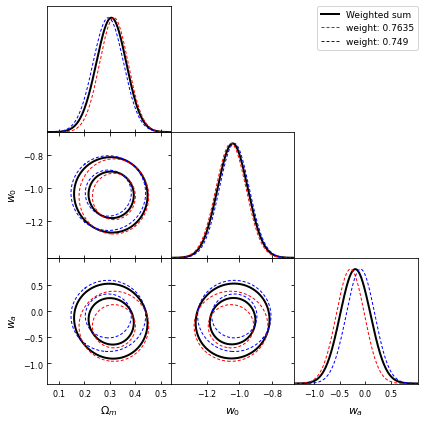

In [13]:
g = plots.get_subplot_plotter()
g.triangle_plot(separate_normals, legend_labels=separate_labels, contour_lws=[2.0, *[1.0 for N in range(N_gauss)]], contour_ls=['-', *['--' for N in range(N_gauss)]])
print(f"Compare the plot with the true parameter values:\n{true_param}")

Compare the plot with the true parameter values:
{'h': 0.7, 'Omega_m': 0.29, 'w0': -1.02, 'wa': 0.01}


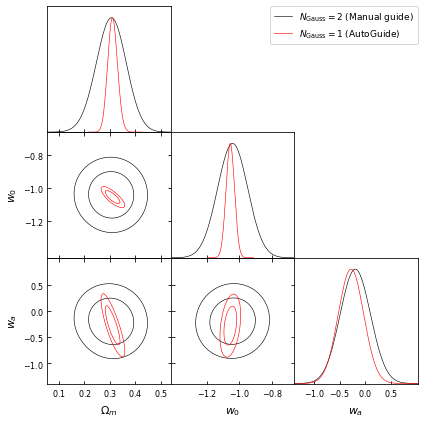

In [14]:
g = plots.get_subplot_plotter()
g.triangle_plot([mixture, single_samples], legend_labels=[r'$N_\mathrm{Gauss}=$'+str(N_gauss)+' (Manual guide)', r'$N_\mathrm{Gauss} = 1$ (AutoGuide)'])
print(f"Compare the plot with the true parameter values:\n{true_param}")